In [1]:
# %%
# Imports
import numpy as np
import pandas as pd
import scipy.sparse as sp
import scipy.ndimage as ndi
import json
from pathlib import Path
from PIL import Image

import squidpy as sq
import spatialdata as sd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from skimage.transform import resize

/mnt/c/Users/mahsa/OneDrive/Documents/FAll2025/istarc/.heat_diffusion/lib/python3.13/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/mnt/c/Users/mahsa/OneDrive/Documents/FAll2025/istarc/.heat_diffusion/lib/python3.13/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/mnt/c/Users/mahsa/OneDrive/Documents/FAll2025/istarc/.heat_diffusion/lib/python3.13/site-packages/spatialdata/_core/query/relational_query.py:532: FutureWar

In [2]:
# %%
# Load Visium data from SpatialData Zarr
sdata = sd.read_zarr(
    store="../data/mouse_brain_visium_hd.sdata.zarr"
)
adata = sdata.tables[list(sdata.tables.keys())[0]]
visium_genes = set(adata.var_names)

print("Loaded AnnData with shape:", adata.shape)

version mismatch: detected: RasterFormatV02, requested: FormatV04
/mnt/c/Users/mahsa/OneDrive/Documents/FAll2025/istarc/.heat_diffusion/lib/python3.13/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
version mismatch: detected: RasterFormatV02, requested: FormatV04
/mnt/c/Users/mahsa/OneDrive/Documents/FAll2025/istarc/.heat_diffusion/lib/python3.13/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


Loaded AnnData with shape: (2702, 32285)


In [3]:
expr_df = adata.to_df()
print("Expression DataFrame shape:", expr_df.shape)


Expression DataFrame shape: (2702, 32285)


In [4]:
root = Path("../data/visium_adult_mouse_brain")
sf_path = root / "spatial" / "scalefactors_json.json"
hires_img_path = root / "spatial" / "tissue_hires_image.png"

# Load scalefactors
with open(sf_path) as f:
    sf = json.load(f)

s_hires = float(sf["tissue_hires_scalef"])
spot_diam_full = float(sf["spot_diameter_fullres"])
spot_diam_hires = spot_diam_full * s_hires

dpi = 150
size_pts2 = (spot_diam_hires * (72.0 / dpi)) ** 2
print("tissue_hires_scalef:", s_hires)
print("spot_diameter_fullres:", spot_diam_full)
print("spot_diam_hires:", spot_diam_hires)


tissue_hires_scalef: 0.17011142
spot_diameter_fullres: 89.43859978699531
spot_diam_hires: 15.21452721257747


In [5]:
img_np = np.asarray(Image.open(hires_img_path))
H, W = img_np.shape[:2]
print("H&E image shape (H, W, C):", img_np.shape)

H&E image shape (H, W, C): (2000, 1921, 3)


In [6]:
xy_full = np.asarray(adata.obsm["spatial"], dtype=float)[:, :2]
xy_hires_guess = xy_full * s_hires
needs_swap = not (
    (xy_hires_guess[:, 0].max() <= W)
    and (xy_hires_guess[:, 1].max() <= H)
)

if needs_swap:
    print("Swapping x and y for spatial coordinates.")
    adata.obsm["spatial_swapped"] = xy_full[:, [1, 0]]
    spatial_key = "spatial_swapped"
else:
    spatial_key = "spatial"

print("Using spatial_key:", spatial_key)


Using spatial_key: spatial


In [7]:
cm_path = Path("../data/cell_markers/normalized_cellmarkers2.csv")
cm = pd.read_csv(cm_path)

marker_genes = (
    cm["marker_gene"]
    .astype(str)
    .dropna()
    .unique()
    .tolist()
)

genes_in_data = [g for g in marker_genes if g in adata.var_names]
print(f"Total marker genes in CSV: {len(marker_genes)}")
print(f"Marker genes present in Visium data: {len(genes_in_data)}")

genes_for_pixels = ["Apoo", "Agap2"]  # or subset if needed


Total marker genes in CSV: 2725
Marker genes present in Visium data: 2725


In [8]:
from tqdm import tqdm

def make_pixel_gene_maps(
    adata,
    genes,
    expr_df,
    H,
    W,
    s_hires,
    spot_diam_hires,
    spatial_key="spatial",
    sigma_mult=0.7,
):
    """
    For each gene:
      - take raw spot expression from expr_df
      - place each spot value at the nearest pixel position on the H&E grid
      - apply Gaussian blur to spread expression over nearby pixels
    Returns: (H, W, G) array of pixel level maps
    """
    coords = np.asarray(adata.obsm[spatial_key], dtype=float)[:, :2]
    xy_pix = coords * float(s_hires)

    # Gaussian sigma in pixels based on a fraction of the spot radius
    spot_radius_pix = spot_diam_hires / 2.0
    sigma = sigma_mult * spot_radius_pix

    G = len(genes)
    pixel_maps = np.zeros((H, W, G), dtype=np.float32)

    # tqdm progress bar
    for gi, g in enumerate(tqdm(genes, desc="Building pixel-level maps")):
        if g not in expr_df.columns:
            print(f"Warning: {g} not in expr_df; skipping.")
            continue

        spot_vals = expr_df[g].to_numpy().astype(float)

        canvas = np.zeros((H, W), dtype=np.float32)

        # Drop spot-level values onto pixel grid
        for (x, y), v in zip(xy_pix, spot_vals):
            ix = int(round(x))
            iy = int(round(y))
            if 0 <= ix < W and 0 <= iy < H:
                canvas[iy, ix] += v

        # Gaussian blur
        if sigma > 0:
            canvas = ndi.gaussian_filter(canvas, sigma=sigma)

        pixel_maps[:, :, gi] = canvas

    return pixel_maps


In [14]:
# After you load the H&E image
img_np = np.asarray(Image.open(hires_img_path))
H_img, W_img = img_np.shape[:2]  # (2000, 1921)

# Build heat-diffused maps at full image resolution
pixel_maps_full = make_pixel_gene_maps(
    adata=adata,
    genes=genes_for_pixels,
    expr_df=expr_df,
    H=H_img,
    W=W_img,
    s_hires=s_hires,
    spot_diam_hires=spot_diam_hires,
    spatial_key=spatial_key,
    sigma_mult=1.2,
)

print("Full-res pixel maps shape:", pixel_maps_full.shape)


Building pixel-level maps: 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]

Full-res pixel maps shape: (2000, 1921, 2)


In [15]:
# Resize to iSTAR embedding size (912x880) for comparison
ge_pixel_maps = resize(
    pixel_maps_full,
    (912, 880, pixel_maps_full.shape[2]),
    preserve_range=True,
    anti_aliasing=True,
).astype(np.float32)

print("Resized pixel maps shape:", ge_pixel_maps.shape)
# -> (912, 880, 2)


Resized pixel maps shape: (912, 880, 2)


In [16]:
if len(genes_for_pixels) > 0:
    gene = genes_for_pixels[0]
    col = gene

    spot_vals = expr_df[col].to_numpy()

    coords = np.asarray(adata.obsm[spatial_key], dtype=float)[:, :2]
    xy_pix = coords * float(s_hires)

    gene_idx = 0  # index of the gene in ge_pixel_maps corresponding to genes_for_pixels[0]
    H_pm, W_pm = ge_pixel_maps.shape[:2]
    pixel_samples = []
    for (x, y) in xy_pix:
        ix = int(round(x))
        iy = int(round(y))
        if 0 <= ix < W_pm and 0 <= iy < H_pm:
            pixel_samples.append(ge_pixel_maps[iy, ix, gene_idx])
        else:
            pixel_samples.append(np.nan)

    ...


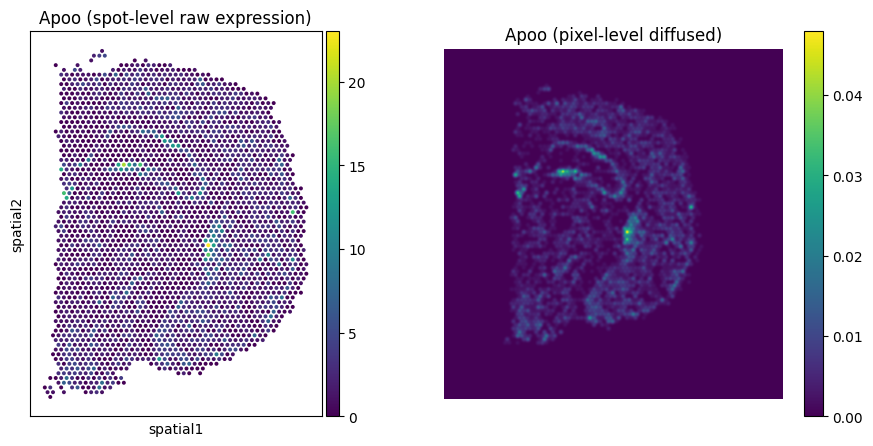

In [17]:
import matplotlib.pyplot as plt

gene = genes_for_pixels[0]
gidx = 0  # index for this gene in ge_pixel_maps

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: spot-level raw expression
sq.pl.spatial_scatter(
    adata,
    color=gene,
    img=None,
    spatial_key=spatial_key,
    size=50,
    ax=axes[0],
)
axes[0].set_title(f"{gene} (spot-level raw expression)")

# Right: pixel-level diffused map (resized to 912x880)
im = axes[1].imshow(ge_pixel_maps[:, :, gidx], cmap="viridis")
axes[1].set_title(f"{gene} (pixel-level diffused)")
axes[1].axis("off")
fig.colorbar(im, ax=axes[1])

plt.show()


In [18]:
adata.write_h5ad("../data/heat_diffused_datavisium_mouse_brain_heat.h5ad")  # contains raw spots only
np.save("../data/heat_diffused_data/visium_mouse_brain_img.npy", img_np)
np.save("../data/heat_diffused_data/visium_mouse_brain_pixel_gene_maps.npy", ge_pixel_maps)

print("Saved h5ad, image, and pixel x gene maps.")

Saved h5ad, image, and pixel x gene maps.


In [20]:
# Directory where you are saving the heat-diffused npy file
out_dir = Path("../data/heat_diffused_data")
out_dir.mkdir(parents=True, exist_ok=True)

# Save the gene list (.txt)
genes_txt_path = out_dir / "visium_mouse_brain_pixel_gene_maps_genes.txt"
with open(genes_txt_path, "w") as f:
    for g in genes_for_pixels:
        f.write(g + "\n")

print("Saved gene list to:", genes_txt_path)


Saved gene list to: ../data/heat_diffused_data/visium_mouse_brain_pixel_gene_maps_genes.txt
